<a href="https://colab.research.google.com/github/max1nehour/Python_projects/blob/main/LSTM_monthly_practice_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import matplotlib.dates as mdates
import pandas as pd
from glob import glob

#列出檔名開頭pm25的檔案
dataset_train = glob('drive/MyDrive/pm25/1718data/pm25*.csv')
print(dataset_train)

dataset_test = glob('drive/MyDrive/pm25/20data/pm25*.csv')
print(dataset_test)

#以列合併train data 僅讀取'Date','area','PM2_5_avg' 設定欄位資料型態'Date': str, 'area':str
df_train = pd.concat(
    (pd.read_csv(file, usecols=['Date','area','PM2_5_avg'], dtype={ 'Date': str, 'area':str}) for file in dataset_train ), ignore_index=True)
print(df_train)

df_test = pd.concat(
    (pd.read_csv(file, usecols=['_monitordate_','area','avg'], dtype={ 'Date': str, 'area':str}) for file in dataset_test ), ignore_index=True)
print(df_test)




['drive/MyDrive/pm25/1718data/pm25嘉義第二包.csv', 'drive/MyDrive/pm25/1718data/pm25忠明第二包.csv', 'drive/MyDrive/pm25/1718data/pm25斗六第二包.csv', 'drive/MyDrive/pm25/1718data/pm25小港第二包.csv', 'drive/MyDrive/pm25/1718data/pm25板橋第二包.csv', 'drive/MyDrive/pm25/1718data/pm25花蓮第二包.csv']
['drive/MyDrive/pm25/20data/pm25花蓮2020.csv', 'drive/MyDrive/pm25/20data/pm25嘉義2020.csv', 'drive/MyDrive/pm25/20data/pm25小港2020.csv', 'drive/MyDrive/pm25/20data/pm25板橋2020.csv', 'drive/MyDrive/pm25/20data/pm25忠明2020.csv', 'drive/MyDrive/pm25/20data/pm25斗六2020.csv']
           Date     area  PM2_5_avg
0    2017-01-31   Chiayi  38.983884
1    2017-02-24   Chiayi  40.523379
2    2017-03-26   Chiayi  42.621849
3    2017-04-25   Chiayi  46.797105
4    2017-05-31   Chiayi  24.429865
..          ...      ...        ...
211  2019-08-31  Hualien   7.620267
212  2019-09-24  Hualien   8.299339
213  2019-10-24  Hualien  15.643017
214  2019-11-29  Hualien  10.236687
215  2019-12-23  Hualien   6.559387

[216 rows x 3 columns]
   _moni

In [55]:
# Import the training set 2019以前
site = 'Banqiao'
filt = (df_train['area'] == site)
training_set = df_train.loc[filt, ['PM2_5_avg']].values
print(training_set)
training_set.shape

# test set
filt2 = (df_test['area'] == site)
test_set = df_test.loc[filt2, ['avg']].values
print(test_set)
print(test_set.shape)

[[14.50835252]
 [20.40615633]
 [29.65714351]
 [34.47449893]
 [19.08261153]
 [17.86702759]
 [19.91077406]
 [14.99579404]
 [21.10765268]
 [16.44418772]
 [12.04146415]
 [11.2013595 ]
 [10.15576012]
 [27.01955439]
 [24.05622771]
 [23.15461358]
 [19.82235905]
 [13.95290511]
 [12.60416938]
 [15.23721583]
 [14.2355624 ]
 [15.28580715]
 [12.29983334]
 [16.72769845]
 [13.0116668 ]
 [19.37830189]
 [16.75610089]
 [23.18629264]
 [16.77331914]
 [10.57171828]
 [13.53532247]
 [ 8.98176167]
 [10.05276341]
 [22.09702474]
 [17.30739096]
 [15.67320769]]
[[16.87096774]
 [17.79310345]
 [17.41935484]
 [16.5       ]
 [13.22580645]
 [ 9.67741935]
 [12.93333333]
 [ 8.82307692]
 [ 7.94117647]
 [ 9.06666667]
 [ 9.86666667]
 [ 9.16129032]]
(12, 1)


做 Normalization，將資料壓縮在 [0,1] 之間

In [56]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1)) #控制最大值最小值範圍
training_set_scaled = sc.fit_transform(training_set)#fit_transform: 先對partData作fit()的功能，找到該partData的整體統計特性之指標，如平均值、標準差、最大最小值等等(能依據不同目的套用這些指標在不同的轉換(即後面的transform()動作)上，再實行transform(partData)以對partData進行標準化
print(training_set_scaled.shape)
#training_set_scaled = training_set

(36, 1)


準備進入訓練的資料格式：設定 Timestep 設為 60 ，代表過去 60 天的資訊，嘗試過數值設置太少，將使 RNN 無法學習。

In [57]:
X_train = []
y_train = []
for i in range(1, 36):  # 訓練集總數36
    X_train.append(training_set_scaled[i-1:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

Reshape
因為現在 X_train 是 2-dimension，將它 reshape 成 3-dimension: [stock prices, timesteps, indicators]

In [58]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#搭建一個 LSTM

In [59]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

搭建 LSTM layer

units: 神經元的數目

第一層的 LSTM Layer 記得要設定input_shape參數

搭配使用dropout，這裡設為 0.2

由於這邊的第四層 LSTM Layer 即將跟 Ouput Layer 做連接，因此注意這邊的 return_sequences 設為預設值 False （也就是不用寫上 return_sequences）

In [60]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [61]:
# Adding the output layer
regressor.add(Dense(units = 1))

#Compiling & Fitting LSTM model

optimizer: 選擇 Adam

loss: 使用 MSE

In [73]:
# Compiling
import tensorflow as tf
from keras import optimizers
from keras import metrics
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[metrics.mae, metrics.sparse_top_k_categorical_accuracy]) #adam is good at time series data
print(X_train.shape)
# 進行訓練
history = regressor.fit(X_train, y_train, epochs = 10, batch_size = 8, validation_split=0.2)
# val_loss 驗證集損失: 比訓練集損失小，是一個好的表現
# Val_accuracy 驗證集準確率
# val_accuracy 衡量模型在未見過的數據上的預測準確性

(35, 1, 1)
Epoch 1/10
4/4 [==============================] - 10s 512ms/step - loss: 0.0424 - mean_absolute_error: 0.1677 - sparse_top_k_categorical_accuracy: 0.9643 - val_loss: 0.0498 - val_mean_absolute_error: 0.2032 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 0s 21ms/step - loss: 0.0411 - mean_absolute_error: 0.1717 - sparse_top_k_categorical_accuracy: 0.9643 - val_loss: 0.0486 - val_mean_absolute_error: 0.2002 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 0s 15ms/step - loss: 0.0393 - mean_absolute_error: 0.1574 - sparse_top_k_categorical_accuracy: 0.9643 - val_loss: 0.0458 - val_mean_absolute_error: 0.1927 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 0s 15ms/step - loss: 0.0438 - mean_absolute_error: 0.1616 - sparse_top_k_categorical_accuracy: 0.9643 - val_loss: 0.0446 - val_mean_absolute_error: 0.1892 - val_sparse_top_k_cate

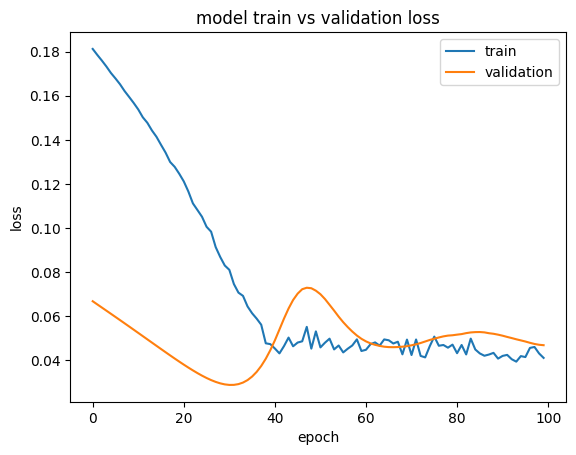

In [63]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

# 進行預測

In [74]:
#取測試 2020的pm2.5
real_pm25 = test_set
print(real_pm25.shape) #61
print(real_pm25)

(12, 1)
[[16.87096774]
 [17.79310345]
 [17.41935484]
 [16.5       ]
 [13.22580645]
 [ 9.67741935]
 [12.93333333]
 [ 8.82307692]
 [ 7.94117647]
 [ 9.06666667]
 [ 9.86666667]
 [ 9.16129032]]


In [76]:
#取模型所預測的 2017 年股票資料（預測
dataset_total = pd.concat((df_train['PM2_5_avg'], df_test['avg']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(df_test) - 1:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling

X_test = []
for i in range(1,13): # timesteps
    X_test.append(inputs[i- 1:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

In [77]:
#進行預測
predicted_pm25 = regressor.predict(X_test)
predicted_pm25 = sc.inverse_transform(predicted_pm25)  # to get the original scale

1/1 [==============================] - 1s 1s/step


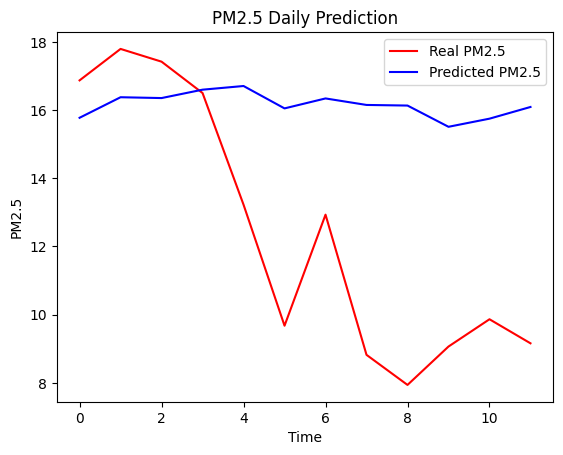

In [78]:
#x = df_test['Date']
plt.plot(real_pm25, color = 'red', label = 'Real PM2.5')  # 紅線表示真實股價
plt.plot(predicted_pm25, color = 'blue', label = 'Predicted PM2.5')  # 藍線表示預測股價
plt.title('PM2.5 Daily Prediction')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


In [79]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(real_pm25.shape)
print(predicted_pm25.shape)

real = pd.DataFrame(real_pm25)
predict = pd.DataFrame(predicted_pm25)

real.fillna(real.mean(), inplace=True)
predict.fillna(predict.mean(), inplace=True)

rmse = np.sqrt(mean_squared_error(real, predict[0:12]))
mae = mean_absolute_error(real, predict[0:12])

print("RMSE:", rmse)
print("MAE:", mae)

(12, 1)
(12, 1)
RMSE: 5.112044581523066
MAE: 4.309259480953484


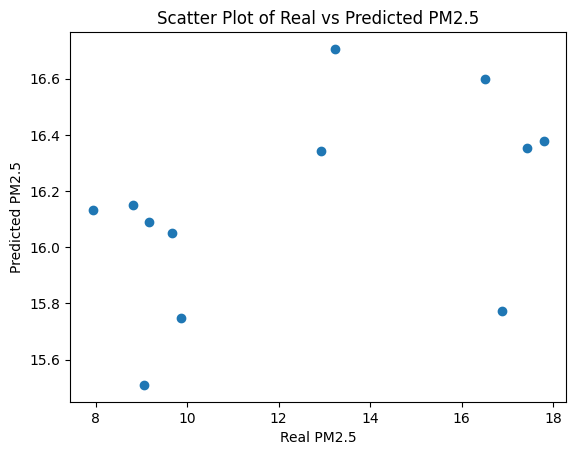

In [80]:
plt.scatter(real_pm25, predicted_pm25)
plt.xlabel('Real PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Scatter Plot of Real vs Predicted PM2.5')
plt.show()